In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import glob
from astropy.io.fits import getdata, getheader, writeto, append, setval

In [2]:
def write_spec(outspec, exp, outname='draft.pha', det_id= 0, mod='A'):
    # Read the template
    null, hdr = getdata('nu30001039002_srcA_sr.pha', 0, header=True)
    writeto(outname, null, header=hdr, overwrite=True)
    spec, hdr = getdata('nu30001039002_srcA_sr.pha', 1, header=True)
    spec['COUNTS'] = outspec
    hdr['RESPFILE'] = 'det{}{}.rmf'.format(det_id, mod)
    hdr['BACKFILE'] = ''
    hdr['ANCRFILE'] = ''
    hdr['EXPOSURE'] = exp
    append(outname, spec, hdr)


In [3]:
def read_spec(infile, det_id=0):
    # returns spec, edges, exposure
    evdata = getdata(infile, 1)

    # Just take DET0 and GRADE==0 for now:
    filter = ( (evdata['GRADE']==0) & (evdata['DET_ID']==det_id) & (evdata['LIMB_ANGLE'] < -2) )
    inds = filter.nonzero()
    
    ehist, edges = np.histogram(evdata['PI'][inds[0]], range = [0, 4096],
                       bins=4096)
    return ehist, edges

In [4]:
def load_data(mod='A', det_id = 0):
    # Returns the full mission data unbinned spectrum
    # set divided into epochs along with exposure.
    
    # Setup NuSTAR time epochs:
    launch_met=77241600. # 2012-06-13T00:00:00
    # Yearly plots for now
    epochs = 6


    spec = np.zeros([epochs, 4096])
    exp = np.zeros(epochs)

    for ind, file in enumerate(glob.glob('../full_mission/*'+mod+'_02*')):

        # Skip these high background obsids
        if file.find("40101012") != -1:
            continue

        if file.find("30161002002") != -1:
            continue

        hdr= getheader(file, 1)
        epoch = np.float(hdr['TSTART'])
        dt_years = (epoch-launch_met) / 3.154e7 # years
        epoch_ind = np.int(np.floor(dt_years))


        ehist, edges = read_spec(file, det_id=det_id)
        spec[epoch_ind, :]+=ehist
        exp[epoch_ind] +=np.float(hdr['EXPOSURE'])
        
    return spec, exp

In [5]:
for mod in ['A', 'B']:
    for det_id in np.arange(4):

        spec, exp = load_data(mod=mod, det_id = det_id)


        for ind in np.arange(len(spec[:, 0])):
            if(exp[ind] == 0):
                continue
            outname='../pha_files/year{}_det{}_FPM{}.pha'.format(ind, det_id, mod)
            print(outname)
            write_spec(spec[ind, :], exp[ind], det_id = det_id, mod = mod, outname=outname)


../pha_files/year0_det0_FPMA.pha
../pha_files/year1_det0_FPMA.pha
../pha_files/year2_det0_FPMA.pha
../pha_files/year3_det0_FPMA.pha
../pha_files/year4_det0_FPMA.pha
../pha_files/year5_det0_FPMA.pha
../pha_files/year0_det1_FPMA.pha
../pha_files/year1_det1_FPMA.pha
../pha_files/year2_det1_FPMA.pha
../pha_files/year3_det1_FPMA.pha
../pha_files/year4_det1_FPMA.pha
../pha_files/year5_det1_FPMA.pha
../pha_files/year0_det2_FPMA.pha
../pha_files/year1_det2_FPMA.pha
../pha_files/year2_det2_FPMA.pha
../pha_files/year3_det2_FPMA.pha
../pha_files/year4_det2_FPMA.pha
../pha_files/year5_det2_FPMA.pha
../pha_files/year0_det3_FPMA.pha
../pha_files/year1_det3_FPMA.pha
../pha_files/year2_det3_FPMA.pha
../pha_files/year3_det3_FPMA.pha
../pha_files/year4_det3_FPMA.pha
../pha_files/year5_det3_FPMA.pha
../pha_files/year0_det0_FPMB.pha
../pha_files/year1_det0_FPMB.pha
../pha_files/year2_det0_FPMB.pha
../pha_files/year3_det0_FPMB.pha
../pha_files/year4_det0_FPMB.pha
../pha_files/year5_det0_FPMB.pha
../pha_fil

In [ ]:
spec = np.zeros([6, 4096])
exp = np.zeros(6)
for mod in ['A', 'B']:
    for ind, file in enumerate(glob.glob('../full_mission/*'+mod+'_02*')):

        if file.find("40101012") != -1:
            continue

        if file.find("30161002002") != -1:
            continue

        evdata = getdata(file, 1)
        hdr= getheader(file, 1)
        epoch = np.float(hdr['TSTART'])
        dt_years = (epoch-launch_met) / 3.154e7 # years
        epoch_ind = np.int(np.floor(dt_years))



        # Just take DET0 and GRADE==0 for now:
        filter = ( (evdata['GRADE']==0) & (evdata['DET_ID']==0) & (evdata['LIMB_ANGLE'] < -2) )
        inds = filter.nonzero()

        ehist, edges = np.histogram(evdata['PI'][inds[0]], range = [0, 4096],
                           bins=4096)
        spec[epoch_ind, :]+=ehist
        exp[epoch_ind] += np.float(hdr['EXPOSURE'])
        break
        
    
#     if(epoch_ind == 38):
#         inrange = (energies>30) * (energies <45)
#         scale = ehist[inrange.nonzero()].mean()


#         print(file, hdr['DATE-OBS'], 1e3* scale/(0.04*np.float(hdr['EXPOSURE'])) )


year0_det1_fpma.pha
year1_det1_fpma.pha
year2_det1_fpma.pha
year3_det1_fpma.pha
year4_det1_fpma.pha
year5_det1_fpma.pha


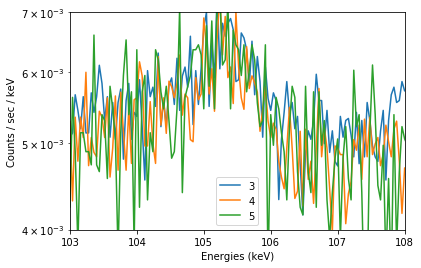

In [25]:
from astropy.convolution import convolve, Box1DKernel
energies = np.arange(4096) * 0.04 + 1.6
smt_size=1
for ind in np.arange(len(spec[:, 0])):
    if(exp[ind] == 0):
        continue
    
    outname='year{}_det1_fpma.pha'.format(ind)
    print(outname)
#    write_spec(spec[ind, :], exp[ind], outname=outname)
    pltspec = convolve(spec[ind, :],Box1DKernel(smt_size))/(0.04*exp[ind])
    if(ind==0):
        inrange = (energies>104) * (energies <106)
        scale = pltspec[inrange.nonzero()].max()
    #    print(scale)
    #    if(scale > 1e-3):
    #        print(ind)
        # If you want to scale over some energy range, do that here...
    pltspec *= scale / pltspec[inrange.nonzero()].max() 
    if (ind>2):
        plt.semilogy(energies[0:4096], pltspec ,
                    label=str(ind))
plt.ylabel('Counts / sec / keV')
plt.xlabel('Energies (keV)')
plt.xlim(103, 108)
plt.ylim(4e-3, 7e-3)
plt.legend()
plt.show()
